In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import time

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
full_train_dataset = datasets.FashionMNIST('path', download=True, transform=transform)
test_dataset = datasets.FashionMNIST('path', train=False, download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:02<00:00, 13128338.25it/s]


Extracting path/FashionMNIST/raw/train-images-idx3-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 210666.64it/s]


Extracting path/FashionMNIST/raw/train-labels-idx1-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3840177.78it/s]


Extracting path/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to path/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6709843.69it/s]

Extracting path/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to path/FashionMNIST/raw



In [ ]:
torch.manual_seed(42)
np.random.seed(42)
full_train_size = len(full_train_dataset)
sizes = [int(full_train_size * 0.01), int(full_train_size * 0.1), full_train_size - int(full_train_size * 0.11)]
train_subset_1, train_subset_10, _ = random_split(full_train_dataset, sizes)

In [ ]:
batch_sizes = [16, 100, 200]
data_loaders = {size: {batch_size: DataLoader(dataset, batch_size=batch_size, shuffle=True)
                      for batch_size in batch_sizes}
                for size, dataset in [('1%', train_subset_1), ('10%', train_subset_10), ('100%', full_train_dataset)]}

test_data_loaders = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [ ]:
class CNNNetwork(nn.Module):
  def __init__(self, num_output_channels, filter_size, pool_size, num_classes):
    super(CNNNetwork, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=num_output_channels, kernel_size=filter_size)
    self.pool = nn.MaxPool2d(kernel_size=pool_size)
    self.fc = nn.LazyLinear(out_features=num_classes)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = torch.flatten(x, 1)
    x = self.fc(x)
    return x

In [ ]:
def plot_costs(train_cost, test_cost, title, axis, pos):
  n = len(train_cost)
  axis[pos].plot(range(n), train_cost, label="Train cost")
  axis[pos].plot(range(n), test_cost, label="Test cost")
  axis[pos].set_title(title)
  axis[pos].set_xlabel("Epochs")
  if (pos == 0):
    axis[pos].set_ylabel("Cost")
  axis[pos].legend()

import warnings
warnings.filterwarnings('ignore')

In [ ]:
input_size = 28 * 28
output_size = 10
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def add_gaussian_noise(data, mean=0, std=0.5):
  noise = torch.randn_like(data) * std + mean
  noisy_data = data + noise
  return noisy_data

def train(model, optimizer, loss_fn, num_epochs, batch_size, train_loader, test_loader, train_noise, test_noise):
  train_cost_list = []
  test_cost_list = []
  best_acc = 0.0
  for epoch in range(num_epochs):
    torch.manual_seed(42)
    for phase in ["train", "test"]:
      if phase == "train":
        model.train()
        data_loader = train_loader
      else:
        model.eval()
        data_loader = test_loader

      total_loss = 0.0
      test_corrects = 0

      for i, (images, labels) in enumerate(data_loader):
        if (phase == "train" and train_noise) or (phase == "test" and test_noise):
          images = add_gaussian_noise(images)
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == "train"):
          outputs = model(images)
          loss = criterion(outputs, labels)
          if phase == "train":
            loss.backward()
            optimizer.step()
          else:
            test_corrects += torch.sum(torch.argmax(outputs, dim=1) == labels)

        total_loss += loss.item()

      avg_loss = total_loss / len(data_loader)

      if phase == "train":
        train_cost_list.append(avg_loss)
      else:
        test_cost_list.append(avg_loss)
        acc = test_corrects / len(data_loader.dataset)
        if acc > best_acc:
          best_acc = acc

  return train_cost_list, test_cost_list, best_acc

Output channels: 16 :  tensor(0.8988, device='cuda:0')
Output channels: 32 :  tensor(0.9045, device='cuda:0')
Output channels: 128 :  tensor(0.9067, device='cuda:0')


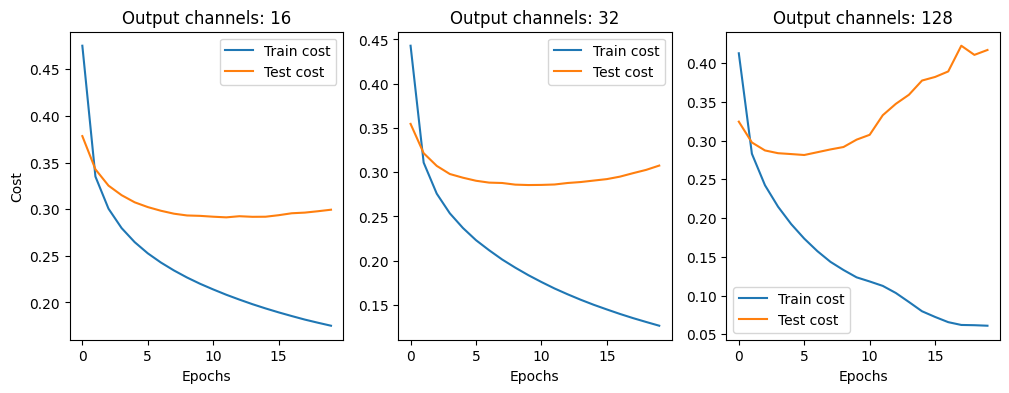

In [ ]:
train_size = "100%"
batch_size = 100
train_noise = False
test_noise = False

num_output_channels_list = [16, 32, 128]
filter_size = 5
pool_size = 2
num_classes = 10

figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(num_output_channels_list)):
  num_output_channels = num_output_channels_list[i]
  model = CNNNetwork(num_output_channels, filter_size, pool_size, num_classes).to(device)
  optimizer = optim.Adam(model.parameters())
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, data_loaders[train_size][batch_size], test_data_loaders, train_noise, test_noise)
  title = "Output channels: " + str(num_output_channels)
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Filter size: 3 :  tensor(0.9026, device='cuda:0')
Filter size: 5 :  tensor(0.9048, device='cuda:0')
Filter size: 11 :  tensor(0.8950, device='cuda:0')


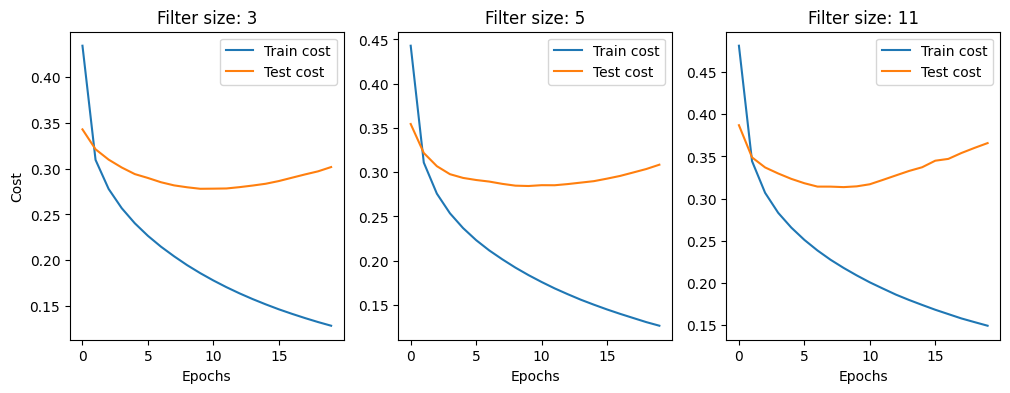

In [ ]:
train_size = "100%"
batch_size = 100
train_noise = False
test_noise = False

filter_size_list = [3, 5, 11]
num_output_channels = 32
pool_size = 2
num_classes = 10

figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(filter_size_list)):
  filter_size = filter_size_list[i]
  model = CNNNetwork(num_output_channels, filter_size, pool_size, num_classes).to(device)
  optimizer = optim.Adam(model.parameters())
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, data_loaders[train_size][batch_size], test_data_loaders, train_noise, test_noise)
  title = "Filter size: " + str(filter_size)
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

Pool size: 2 :  tensor(0.9049, device='cuda:0')
Pool size: 3 :  tensor(0.9030, device='cuda:0')
Pool size: 4 :  tensor(0.9024, device='cuda:0')


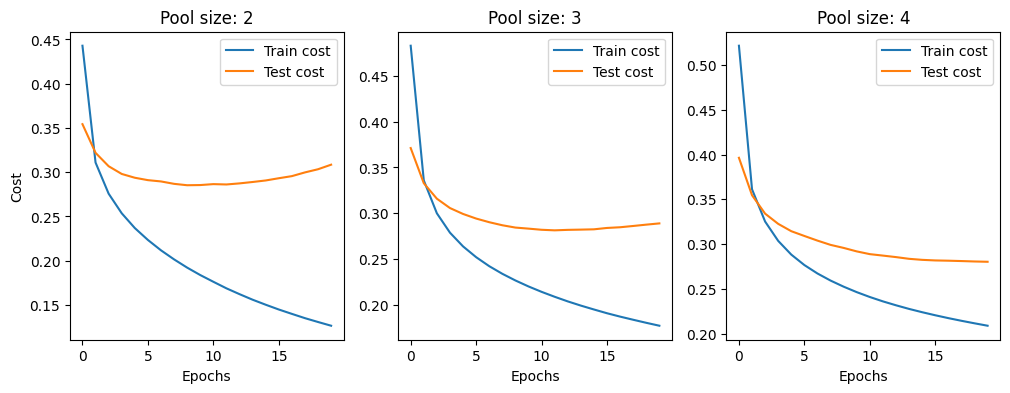

In [ ]:
train_size = "100%"
batch_size = 100
train_noise = False
test_noise = False

pool_size_list = [2, 3, 4]
num_output_channels = 32
filter_size = 5
num_classes = 10

figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(pool_size_list)):
  pool_size = pool_size_list[i]
  model = CNNNetwork(num_output_channels, filter_size, pool_size, num_classes).to(device)
  optimizer = optim.Adam(model.parameters())
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, data_loaders[train_size][batch_size], test_data_loaders, train_noise, test_noise)
  title = "Pool size: " + str(pool_size)
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)

No noise added :  tensor(0.9089, device='cuda:0')
Noise in only test set :  tensor(0.6210, device='cuda:0')
Noise in both train and test sets :  tensor(0.8476, device='cuda:0')


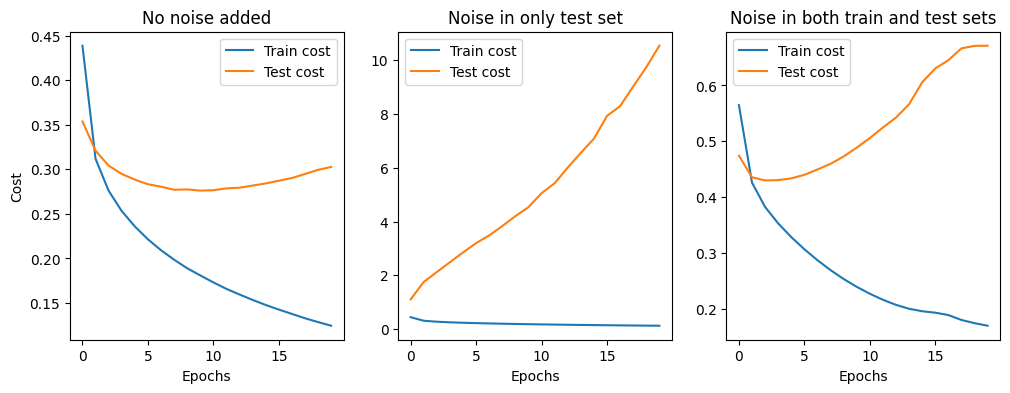

In [ ]:
train_size = "100%"
batch_size = 100
num_output_channels = 32
filter_size = 5
pool_size = 2
num_classes = 10

data_disturbance = [{'train_noise': False, 'test_noise': False},
                    {'train_noise': False, 'test_noise': True},
                    {'train_noise': True, 'test_noise': True}]

figure, axis = plt.subplots(1, 3, figsize=(12, 4))
for i in range(len(data_disturbance)):
  train_noise = data_disturbance[i]['train_noise']
  test_noise = data_disturbance[i]['test_noise']
  model = CNNNetwork(num_output_channels, filter_size, pool_size, num_classes).to(device)
  optimizer = optim.Adam(model.parameters())
  train_cost, test_cost, acc = train(model, optimizer, criterion, num_epochs, batch_size, data_loaders[train_size][batch_size], test_data_loaders, train_noise, test_noise)
  if train_noise and test_noise:
    title = "Noise in both train and test sets"
  elif not train_noise and not test_noise:
    title = "No noise added"
  else:
    title = "Noise in only test set"
  plot_costs(train_cost, test_cost, title, axis, i)
  print(title, ": ", acc)